# Summary:

#### In this spreadsheet, we setup an example of a 'clean' time series and fit an LSTM model to it. The 'clean' time series is given in the form of a sine wave. Error and performance metrics are evaluated.

#### The steps outlined in this notebook will be used in the notebook 02_Freddie_Freeloader to analyze the dependence of model-parameter choices on the backtesting errors.


# Table of contents
* [1. Load modules](#Part1_link)
* [2. Setup data](#Part2_link)
<br >&nbsp;&nbsp;&nbsp;[2.1 Generate time series: sine wave](#Part2.1_link)
<br >&nbsp;&nbsp;&nbsp;[2.2 Separate training and validation data ](#Part2.2_link)

* [3. Feature scaling](#Part3_link)
<br >&nbsp;&nbsp;&nbsp;[3.1 Standardize training data](#Part3.1_link)
* [4. Preprocess data](#Part4_link)
<br >&nbsp;&nbsp;&nbsp;[4.1 Cache, batch and shuffle using Tensorflow's data format](#Part4.1_link)
* [5. Setup and compile model](#Part5_link)
<br >&nbsp;&nbsp;&nbsp;[5.1 LSTM](#Part5.1_link)
<br >&nbsp;&nbsp;&nbsp;[5.2 LSTM](#Part5.2_link)
* [6. Fit model](#Part6_link)
<br >&nbsp;&nbsp;&nbsp;[6.1 LSTM](#Part6.1_link)
* [7. Model forecasts](#Part7_link)
<br >&nbsp;&nbsp;&nbsp;[7.1 Visualize training and validation history](#Part7.1_link)
<br >&nbsp;&nbsp;&nbsp;[7.2 Assess error metrics](#Part7.2_link)

<a id='Part1_link'></a>
# 1. Load modules

In [1]:
import Kind_of_Blue  # own class with a collection of methods used in this analysis

import tensorflow as tf

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import numpy as np
import pandas as pd


<a id='Part2_link'></a>
# 2. Setup data

<a id='Part2.1_link'></a>
### 2.1 Generate time series: sine wave

The dataset used in this initial experiment is a simple sine wave. The number of data points in each period is kept fixed thoughout the analysis.

In [2]:
# set a range of dates on which the observations are made
idx = pd.date_range(end='7/1/2020', periods=10*364, freq='d')

# take a sine function as the observations
num_periods = 20  # number of sine periods
observations = [np.sin(2*np.pi*num_periods*x/len(idx)) for x in range(len(idx))]
print('number of observations in time series: {}'.format(len(observations)))

# initialize dataframe to store time series
df = pd.DataFrame(data=observations, columns=['observations'])
df.index = idx

# initialize object
mdq = Kind_of_Blue.Kind_of_Blue()

# load dataframe into object
mdq._selected_features = ['observations']
mdq.df = df
mdq.df.head()

number of observations in time series: 3640


,observations
2010-07-15,0.000000
2010-07-16,0.034516
2010-07-17,0.068991
2010-07-18,0.103384
2010-07-19,0.137654


<a id='Part2.2_link'></a>
### 2.2 Separate training and validation data 

In [3]:
# train-validation split ratio as class attribute set to 70%
print('train split ratio = ', mdq.TRAIN_SPLIT_RATIO)

train split ratio =  0.7


In [4]:
# initialize dataset from dataframe 
mdq.initialize_dataset()
print('loaded data set length: {}'.format(len(mdq._dataset)))

loaded data set length: 3640


<a id='Part3_link'></a>
# 3. Feature scaling

<a id='Part3.1_link'></a>
### 3.1 Standardize training data

In [5]:
# standardize data
mdq.standardize_data()

# check that mean equals zero and the standard deviation is one
print('mean: {}, std: {}'.format(round(np.mean(mdq._dataset), 2), round(np.std(mdq._dataset), 2)))

mean: 0.0, std: 1.0


<a id='Part4_link'></a>
# 4. Preprocess data

<a id='Part4.1_link'></a>
### 4.1 Cache, batch and shuffle using Tensorflow's data format

The number time points to be forecasted and the number of points the model is trained on are set. The training and validation dataset is generated.

In [6]:
# set number of time points for 1/ future forecasting points and 2/ the past, historical time points
future_target_size = int(365/52)
past_history_size = int(2*365)

# set batch size
batch_size = 32
mdq.generate_train_and_val_data(future_target_size=future_target_size, past_history_size=past_history_size
                                , batch_size=batch_size)

print('number of training samples: {}'.format(mdq._num_samples))

training set shape: x:(1818, 730, 1), y:(1818, 7, 1)
validation set shape: x:(355, 730, 1), y:(355, 7, 1)
number of training samples: 1818


<a id='Part5_link'></a>
# 5. Setup and compile model

<a id='Part5.1_link'></a>
### 5.1 LSTM 

Using Keras, the configuration details of the LSTM model is set and compiled.

In [7]:
# setup Keras LSTM model and compile
units = 16
num_layers = 2
model_type = 'LSTM'
mdq.compile_model(units=units, num_layers=num_layers, model_type=model_type)

# check that model exists in mdq-object
print('test that model got created in object instance: \n', mdq._models)

ToDo2: change a few things in the LSTM setup before running tests
test that model got created in object instance: 
 {'LSTM': <tensorflow.python.keras.engine.sequential.Sequential object at 0x7fab94393610>}


<a id='Part5.2_link'></a>
### 5.2 RNN 

In [ ]:
# now build the RNN
model = Sequential()
model.add(SimpleRNN(128, input_shape = (data_mat_3d_final.shape[1],
    data_mat_3d_final.shape[2]), activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(16, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1, activation='linear'))

model.compile(loss = 'mean_squared_error',
              optimizer = 'adam',
              metrics = ['mse'])

<a id='Part6_link'></a>
# 6. Fit model

<a id='Part6.1_link'></a>
### 6.1 LSTM 

Setting the number of epochs and steps per epoch, the model is fit to the training data. The generated 'history' will be used in the following section to assess the quality of the fit.

In [8]:
# set number of epochs
epochs = 20

# set number of 
num_samples = mdq._num_samples
steps_per_epoch = int(num_samples/batch_size)

validation_steps = int(steps_per_epoch/2)

mdq.fit_model(epochs=epochs, steps_per_epoch=steps_per_epoch
              ,validation_steps=validation_steps)

Epoch 1/20
56/56 [==============================] - 28s 503ms/step - loss: 0.8151 - mse: 0.8151 - val_loss: 0.4681 - val_mse: 0.4681
Epoch 2/20
56/56 [==============================] - 25s 443ms/step - loss: 0.3803 - mse: 0.3803 - val_loss: 0.1387 - val_mse: 0.1387
Epoch 3/20
56/56 [==============================] - 93s 2s/step - loss: 0.2056 - mse: 0.2056 - val_loss: 0.0428 - val_mse: 0.0428
Epoch 4/20
56/56 [==============================] - 449s 8s/step - loss: 0.1469 - mse: 0.1469 - val_loss: 0.0246 - val_mse: 0.0246
Epoch 5/20
56/56 [==============================] - 26s 473ms/step - loss: 0.1203 - mse: 0.1203 - val_loss: 0.0391 - val_mse: 0.0391
Epoch 6/20
56/56 [==============================] - 26s 456ms/step - loss: 0.1004 - mse: 0.1004 - val_loss: 0.0191 - val_mse: 0.0191
Epoch 7/20
56/56 [==============================] - 26s 456ms/step - loss: 0.0993 - mse: 0.0993 - val_loss: 0.0162 - val_mse: 0.0162
Epoch 8/20
56/56 [==============================] - 26s 457ms/step - loss:

In [9]:
total_training_time = sum(mdq._time_callback.times)
print('total training time: {}'.format(total_training_time))

total training time: 1012.1998600959778


<a id='Part7_link'></a>
# 7. loss and error metrics

<a id='Part7.1_link'></a>
### 7.1 Visualize training and validation history

LSTM model

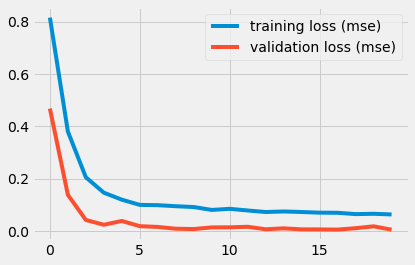

In [10]:
mdq.plot_history()

<a id='Part7.2_link'></a>
### 7.2 Assess error metrics

LSTM model

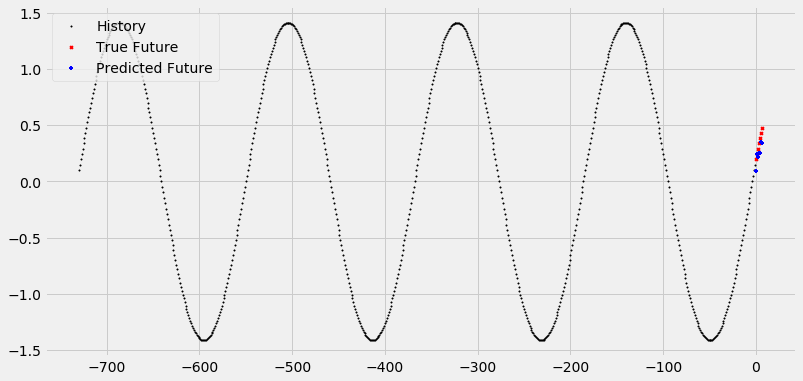

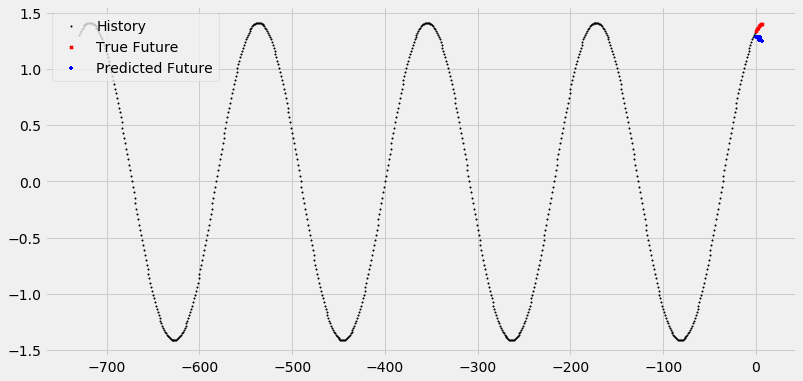

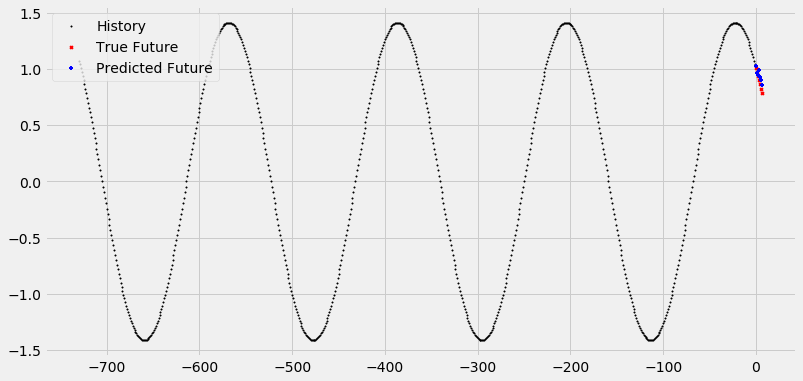

In [11]:
# visualize predictions

num = 2
for x, y in mdq._val_data.take(3):
    mdq.multi_step_plot(x[num], y[num], mdq._model.predict(x)[:1])